In [1]:
import sys
sys.path.append('../')
from megaparse.cdp.utils.diff_agent import DifferenceAgent, ContextType
from megaparse.cdp.utils.query_engine import DiffQueryEngine
from pathlib import Path
from megaparse.cdp.utils.question_generator import QuestionGenerator

In [7]:
DOCUMENT_CONTEXT = """
The document is a list of specificity for a pastry product, specially on the packaging part and physical constraint of the product. Focus on the physical/ packaging part of the document, not the ingredients.
When generating each question, include all relevant information so that the question can be answered without needing to refer back to the table. This is important because the team verifying the specificity will not have access to the table.
Look for the most detail in each ingredient, such as the labels (RSPCO, élevés en cage), do not add the country it is from, do not add the name of the parent ingredient (ex: BASE VERTE)

The questions must be specific.
The number of questions should match the number of informations on the packaging in the document.
The question will be asked directly to the "Charte Emballage" team, they won't have access to the provided document.

Exemple : 
Document states : The product weight is 40kg and the diameter is 110/90 mm.
questions : ["Is a product that weights 40kg with a diameter of 110 (up) and 90 (down) mm compliant with requirements?"]
"""

In [8]:
diff_query_engine = DiffQueryEngine(Path("../megaparse/cdp/CDP_QUAL_CHART_01_CHARTE_PRODUITS.md"), top_k= 15)
question_generator = QuestionGenerator(document_context= DOCUMENT_CONTEXT)

In [9]:
from llama_index.core import PromptTemplate

qa_prompt_tmpl_str = """\
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, every explanations has to be based on elements of the context. \
Answer the query asking about criteria on a specific topic. Note that if it is not detailed in the context, classify the answer as "Authorized".

Query: {query_str}
Answer: \
"""

qa_prompt_tmpl = PromptTemplate(
    qa_prompt_tmpl_str
)

diff_query_engine.query_engine.update_prompts(
    {"response_synthesizer:summary_template": qa_prompt_tmpl}
)

In [10]:
agent = DifferenceAgent(diff_query_engine, document_context= None, question_generator=question_generator)


In [11]:
#Fiche recette
questions: list[str] | None = agent.generate_questions(Path("../megaparse/cdp/exemple_fournisseur.xlsx"), tab_name = 'Fiche technique produit', language_verification= True)
print(len(questions))

Generating Questions ...
Verifying language and translating questions ...
16


In [12]:
questions

["Est-ce que l'utilisation d'une semelle en carton et pellicule plastique, polyester or/polyester noir, de couleur or et noir, en quantité de 4 par carton, est conforme aux exigences?",
 "Est-ce que l'utilisation d'une boîte en carton de couleur blanche, en quantité de 4 par carton, est conforme aux exigences?",
 "Est-ce que l'utilisation d'un carton en carton de couleur blanche, en quantité de 1 par carton, est conforme aux exigences?",
 'Est-ce que le poids net de la pièce de 430g est conforme aux exigences?',
 'Est-ce que la longueur de la pièce de 160mm est conforme aux exigences?',
 'Est-ce que la largeur de la pièce de 80mm est conforme aux exigences?',
 'Est-ce que la hauteur de la pièce de 70mm est conforme aux exigences?',
 'Est-ce que le nombre de pièces dans le colis de 4 est conforme aux exigences?',
 'Est-ce que le poids net du colis de 1.72kg est conforme aux exigences?',
 'Est-ce que les dimensions du colis de L:256mm, l:213mm, H:206mm sont conformes aux exigences?',
 'E

Questions for evaluating the query engine:

'La « Framboise » est-elle conforme aux exigences ?',
 "L'« Eau » est-elle conforme aux exigences ?",
 'Le « Sucre Cristal » est-il conforme aux exigences ?',
 'Le « Sirop de glucose » est-il conforme aux exigences ?',
 "L'« Huile de palmiste » est-elle conforme aux exigences ?",
 "L'« Emulsifiant : E472a (esters d'acide acétique de mono- et diglycérides d'acides gras) » est-il conforme aux exigences ?",
 'La « Protéine de lait » est-elle conforme aux exigences ?',
 'La « Crème de lait » est-elle conforme aux exigences ?',
 'Le « Stabilisant : E407 » est-il conforme aux exigences ?',
 'La « Gélatine bovine » est-elle conforme aux exigences ?',
 "L'« Oeuf entier » est-il conforme aux exigences ?",
 'La « Purée de framboise » est-elle conforme aux exigences ?',
 'La « Pectine » est-elle conforme aux exigences ?',
 'Le « Sucre » dans le « Chocolat blanc » est-il conforme aux exigences ?',
 'La « Poudre de lait entier » dans le « Chocolat blanc » est-elle conforme aux exigences ?',
 'Le « Beurre de cacao » dans le « Chocolat blanc » est-il conforme aux exigences ?',
 "L'« Emulsifiant : E322 (soja) » dans le « Chocolat blanc » est-il conforme aux exigences ?",
 "L'« Arôme naturel de vanille » dans le « Chocolat blanc » est-il conforme aux exigences ?",
 "L'« Huile de tournesol » est-elle conforme aux exigences ?",
 'La « Farine de blé » est-elle conforme aux exigences ?',
 'Le « Beurre concentré » est-il conforme aux exigences ?',
 'Le « Lait écrémé en poudre » est-il conforme aux exigences ?',
 "Le « Malt d'orge » est-il conforme aux exigences ?",
 'Le « Sel » est-il conforme aux exigences ?',
 'Le « Colorant : E160c » est-il conforme aux exigences ?',
 'Le « Jus concentré de betterave » est-il conforme aux exigences ?',
 "Le « Jus concentré d'acérola » est-il conforme aux exigences ?",
 'Le « Jus de citron » est-il conforme aux exigences ?',
 'Le « Gélifiant : E406 » est-il conforme aux exigences ?',
 'Le « Gélifiant : E440 » est-il conforme aux exigences ?',
 "L'« Epaississant : E466 » est-il conforme aux exigences ?",
 "L'« Epaississant : E415 » est-il conforme aux exigences ?",
 "L'« Acidifiant : E330 » est-il conforme aux exigences ?",
 'Le « Conservateur : E202 » est-il conforme aux exigences ?',
 "L'« Hydrolysat de protéines de lait » est-il conforme aux exigences ?",
 "Les « Fibres d'avoine » sont-elles conformes aux exigences ?",
 'Le « Glucose » est-il conforme aux exigences ?',
 'Le « Gélifiant : E440ii » est-il conforme aux exigences ?',
 "L'« Arôme naturel de pistache » est-il conforme aux exigences ?",
 'Le « Gélifiant : E407 (carraghénanes, dextrose) » est-il conforme aux exigences ?',
 "L'« Extrait de spiruline » est-il conforme aux exigences ?"]

In [7]:
# additional_context = ContextType(category='Entree de Gamme', context='pour les produits de la catégorie Entree de Gamme ?')
# agent.run(additional_context=additional_context, verbose=True)

Querying generated questions to the reference document...
1 validation error for Ingredient
used_chunks
  value is not a valid list (type=type_error.list)
Error with question: La Fécule de pomme de terre est-elle conforme aux exigences ?
Retry ...
1 validation error for Ingredient
used_chunks
  value is not a valid list (type=type_error.list)
Error with question: Le Coagulant microbien est-il conforme aux exigences ?
Retry ...
1 validation error for Ingredient
used_chunks
  value is not a valid list (type=type_error.list)
Error with question: Le Conservateur (E202) est-il conforme aux exigences ?
Retry ...
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
Node found
3 validation errors for Ingredient
detailed_answer
  field required (type=value_error.missing)
decis

/Users/chloed./.local/share/virtualenvs/MegaParse-onLGVT8Y/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chloed./.local/share/virtualenvs/MegaParse-onLGVT8Y/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chloed./.local/share/virtualenvs/MegaParse-onLGVT8Y/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

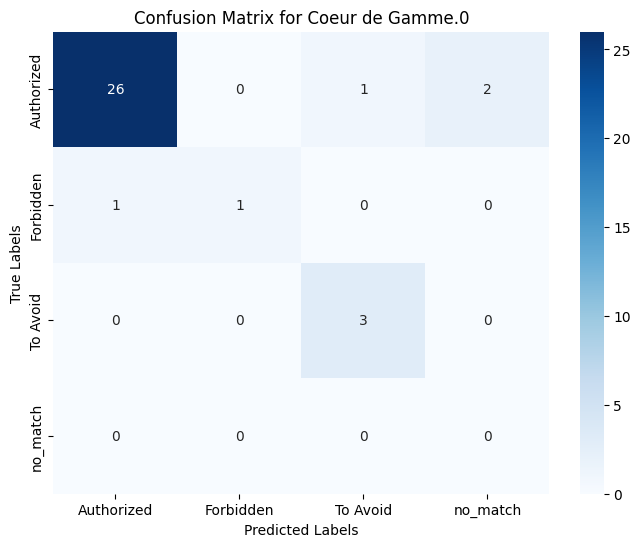

Accuracy: 88.24%
            Precision    Recall
Authorized   0.962963  0.896552
Forbidden    1.000000  0.500000
To Avoid     0.750000  1.000000
no_match     0.000000  0.000000

Metrics for Entree de Gamme.0:


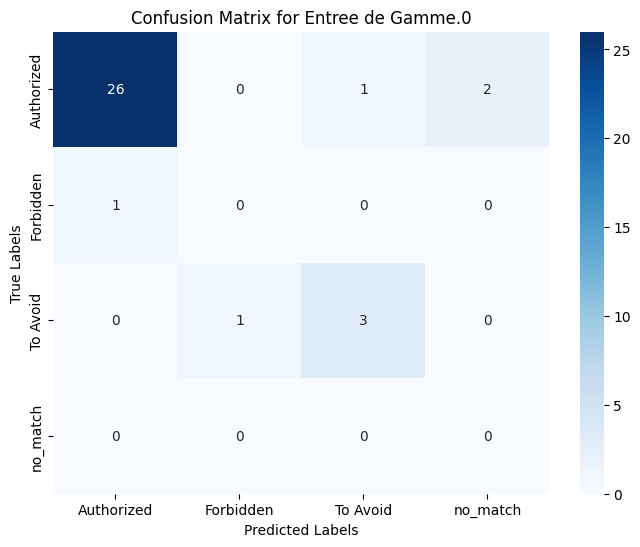

Accuracy: 85.29%
            Precision    Recall
Authorized   0.962963  0.896552
Forbidden    0.000000  0.000000
To Avoid     0.750000  0.750000
no_match     0.000000  0.000000

Metrics for Haut de Gamme.0:


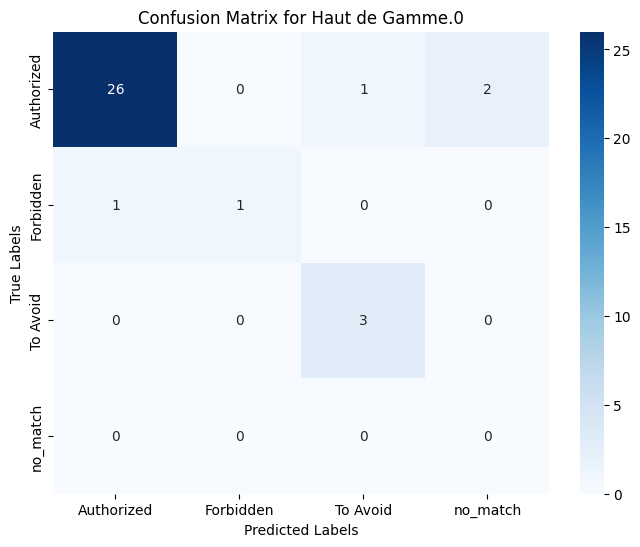

Accuracy: 88.24%
            Precision    Recall
Authorized   0.962963  0.896552
Forbidden    1.000000  0.500000
To Avoid     0.750000  1.000000
no_match     0.000000  0.000000

Overall Metrics:


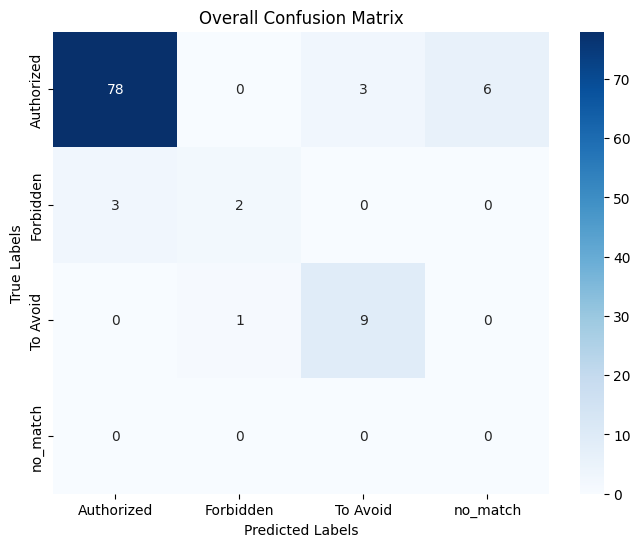

Overall Accuracy: 87.25%
            Precision    Recall
Authorized   0.962963  0.896552
Forbidden    0.666667  0.400000
To Avoid     0.750000  0.900000
no_match     0.000000  0.000000


In [13]:
additional_contexts = [
                        ContextType(category='Coeur de Gamme', context='pour les produits de la catégorie Coeur de Gamme ?'),
                        ContextType(category='Entree de Gamme', context='pour les produits de la catégorie Entree de Gamme ?'),
                        ContextType(category='Haut de Gamme', context='pour les produits de la catégorie Haut de Gamme ?')
                        ]
generated_df = agent.evaluate(source_path= None, target_path= Path('../megaparse/cdp/ground_truth_quiche.csv'), tab_name= None, additional_contexts=additional_contexts, verbose=True, compute_all=True, n_iteration= 1)


In [12]:
print(agent.get_detail("Coeur de Gamme", 0, name = "jaune d'œuf sol")["Coeur de Gamme.0.detail"].values[0])
print(agent.get_detail("Coeur de Gamme", 0, name = "jaune d'œuf sol")["Coeur de Gamme.0"].values[0])

Le jaune d'œuf sol n'est pas conforme aux exigences car les œufs de poules élevées en cage sont interdits dans toutes les gammes de produits.
Forbidden


In [13]:
response = await agent.diff_query_engine.query_engine.aquery("L'« Epaississant : E466 » est-il conforme aux exigences pour les produits de la catégorie Coeur de Gamme ?")
print(response)

{"name": "E466", "detailed_answer": "L'\u00e9paississant E466, \u00e9galement connu sous le nom de carboxym\u00e9thyl-cellulose sodique ou gomme cellulosique, est class\u00e9 parmi les additifs oranges. Pour les produits de la cat\u00e9gorie C\u0153ur de Gamme, les additifs oranges sont \u00e0 \u00e9viter. Par cons\u00e9quent, l'utilisation de l'\u00e9paississant E466 n'est pas conforme aux exigences pour les produits de la cat\u00e9gorie C\u0153ur de Gamme.", "decision": "To Avoid", "used_chunks": [0, 4]}


In [13]:
response = await agent.diff_query_engine.query_engine.aquery("Le « Stabilisant : E407 » est-il conforme aux exigences pour les produits de la catégorie Coeur de Gamme ?")
response

PydanticResponse(response=Ingredient(name='E407', detailed_answer='Le stabilisant E407, également connu sous le nom de carraghénane, est classé parmi les additifs oranges. Les additifs oranges sont ceux pour lesquels les rapports scientifiques sont contradictoires. Pour les produits de la catégorie Cœur de Gamme, les additifs oranges sont à éviter.', decision=<DecisionEnum.to_avoid: 'To Avoid'>, used_chunks=[0, 1]), source_nodes=[NodeWithScore(node=TextNode(id_='45c82c0a-5792-494c-9f04-1025a5279347', embedding=None, metadata={'info_density': 53}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='c9b86108-0958-4b9b-b658-dcc98ccb2943', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='78f3f962d977fc5955368245fea9524b4257887505299c9f064866cd06c532ff')}, text='Chunk #0 : \n 1. Exigence recette\n\nPour le développement de nos produits, nous souhaitons favoriser une offre saine avec des recettes simp

In [14]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='45c82c0a-5792-494c-9f04-1025a5279347', embedding=None, metadata={'info_density': 96}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='c9b86108-0958-4b9b-b658-dcc98ccb2943', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='78f3f962d977fc5955368245fea9524b4257887505299c9f064866cd06c532ff')}, text='Chunk #0 : \n 1. Exigence recette\n\nPour le développement de nos produits, nous souhaitons favoriser une offre saine avec des recettes simples (sans colorant, sans arôme, sans conservateur), avec des ingrédients de qualité, en favorisant des produits locaux et labellisés.\n\nLe fournisseur s’engage à respecter la réglementation européenne et nationale ainsi que les codes d’usages professionnels applicables aux produits surgelés vendus à Coup de Pates.\n\nPour les produits commercialisés sous une marque appartenant à Coup de Pates, le fournisseur s’engage également à

In [18]:
agent.questions

['Le LAIT de chèvre pasteurisé est-il conforme aux exigences ?',
 'Le Sel est-il conforme aux exigences ?',
 'Les Ferments sont-ils conformes aux exigences ?',
 'La Crème est-elle conforme aux exigences ?',
 'Le Stabilisant : carraghénanes est-il conforme aux exigences ?',
 'Le Beurre doux est-il conforme aux exigences ?',
 "L'Abricot sec est-il conforme aux exigences ?",
 "L'Antioxydant : ANHYDRIDE SULFUREUX E220 est-il conforme aux exigences ?",
 "L'Eau est-elle conforme aux exigences ?",
 'Le Vinaigre de vin blanc est-il conforme aux exigences ?',
 'Le Moût de raisin concentré est-il conforme aux exigences ?',
 'Le MétabiSULFITE de potassium est-il conforme aux exigences ?',
 'La Pectine E440 est-elle conforme aux exigences ?',
 'Le Diphosphate E450 est-il conforme aux exigences ?',
 'Le Saccharose est-il conforme aux exigences ?',
 'Le Phosphate de calcium E341 est-il conforme aux exigences ?',
 'Le Sucre cristal est-il conforme aux exigences ?',
 'La Farine de riz est-elle conform

In [19]:
agent.generated_df

,name,Coeur de Gamme.0,Coeur de Gamme.0.detail,Entree de Gamme.0,Entree de Gamme.0.detail,Haut de Gamme.0,Haut de Gamme.0.detail,cleaned_name
0,Framboise,Authorized,Le lait de chèvre pasteurisé est conforme aux ...,Authorized,Le lait de chèvre pasteurisé est conforme aux ...,Authorized,Le lait de chèvre pasteurisé est conforme aux ...,framboise
2,Eau,To Avoid,Les ferments ne sont pas mentionnés spécifique...,To Avoid,Les ferments ne sont pas mentionnés spécifique...,To Avoid,Les ferments ne sont pas mentionnés spécifique...,eau
3,Sucre Cristal,Authorized,La crème n'est pas mentionnée dans les exigenc...,Authorized,La crème est conforme aux exigences si elle ne...,Authorized,La crème n'est pas mentionnée spécifiquement d...,sucre cristal
4,Sirop de glucose,To Avoid,Les carraghénanes (E 407) sont des additifs cl...,To Avoid,Les carraghénanes sont des additifs alimentair...,To Avoid,Les carraghénanes (E 407) sont des additifs al...,sirop de glucose
5,Huile de palmiste,Authorized,Le beurre doux est conforme aux exigences de C...,Authorized,Le beurre doux est conforme aux exigences car ...,Authorized,Le beurre doux est conforme aux exigences car ...,huile de palmiste
6,E472a (esters d'acide acétique de mono- et dig...,Authorized,Les abricots secs sont conformes aux exigences...,Authorized,Les abricots secs sont conformes aux exigences...,Authorized,Les abricots secs sont généralement conformes ...,e472a esters dacide actique de mono et diglycr...
7,Protéine de lait,To Avoid,L'anhydride sulfureux (E220) est classé parmi ...,To Avoid,L'anhydride sulfureux (E220) est classé parmi ...,To Avoid,L'anhydride sulfureux (E220) est classé parmi ...,protine de lait
8,Crème de lait,Authorized,L'eau est conforme aux exigences de Coup de Pa...,Authorized,"L'eau est conforme aux exigences, car elle n'e...",Authorized,"L'eau est conforme aux exigences, car elle ne ...",crme de lait
9,Stabilisants : E407,Authorized,Le vinaigre de vin blanc est conforme aux exig...,Authorized,Le vinaigre de vin blanc est conforme aux exig...,Authorized,Le vinaigre de vin blanc est conforme aux exig...,stabilisants e407
10,Gélatine Bovine 200 Bloom,Authorized,Le moût de raisin concentré n'est pas mentionn...,Authorized,Le moût de raisin concentré n'est pas mentionn...,Authorized,Le moût de raisin concentré est un ingrédient ...,glatine bovine 200 bloom


In [20]:
#response =  diff_query_engine.query_engine.query("Le « Gélifiant : E407 (carraghénanes, dextrose) » est-il conforme aux exigences ?")
response = await agent.diff_query_engine.query_engine.aquery("Le « Gélifiant : E407 (carraghénanes, dextrose) » est-il conforme aux exigences ?")
response

PydanticResponse(response=Ingredient(name='Gélifiant : E407 (carraghénanes, dextrose)', detailed_answer="Le gélifiant E407, également connu sous le nom de carraghénanes, est classé parmi les additifs oranges, ce qui signifie que les rapports scientifiques à son sujet sont contradictoires. Par conséquent, il est recommandé de l'éviter dans les produits de la marque Coup de Pates, bien qu'il ne soit pas strictement interdit.", decision=<DecisionEnum.to_avoid: 'To Avoid'>, used_chunks=[3], more_info='Look into chunk id 3 to verify the classification of E407 as an orange additive.'), source_nodes=[NodeWithScore(node=TextNode(id_='c513f3e0-6ce3-434c-973f-b10496f7f813', embedding=None, metadata={'info_density': 85}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='0c8dc3c8-b4ff-4555-85d2-200b2970fd2b', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='c14b16dbf1d39d40a2dfda2292f356f68ec8d6228d384b48

In [11]:
agent.diff_query_engine.cleaned_nodes

[TextNode(id_='bc8d0242-a784-40f4-9f0e-dcd6b981fe06', embedding=None, metadata={'info_density': 1}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='299d0585-982d-41be-a63e-80b4bdc918f1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='09953039bdb6095b9f45b6bd1cdf14af1c71fcfb86c7482ebc7dad43c35838fd')}, text="CHARTE PRODUITS COUP DE PATES\n\n**Codification**: CDP_QUA_CHART_01  \n**Version**: 5  \n**Date d'application**: 13/12/2023\n\n| Date       | Mises à jour                                                                 |\n|------------|------------------------------------------------------------------------------|\n| 19/12/2014 | Création                                                                     |\n| 12/12/2019 | Insertion des additifs interdits et à éviter                                 |\n| 13/05/2022 | Revue des exigences recettes et annexes                                

In [13]:
response.source_nodes[0].score

0.8433791841632852

In [7]:
nodes_to_update = [response.source_nodes[int(i)] for i in response.response.used_chunks]
nodes_to_update

[NodeWithScore(node=TextNode(id_='07822fbc-4d10-4d8b-81d7-687035608647', embedding=None, metadata={'info_density': 0}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='f3ae2c50-a5e0-4523-ae5e-efc8af607535', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='aa28066ceaf2fd11af479677a1671e4ac22f2a8d0cce390d0b6cfbc847552716')}, text='Chunk #0 : \n ANNEXE II : Additifs oranges : additifs pour lesquels les rapports scientifiques sont contradictoires\n\n| Additif                          | Code  | Additif                                                                 | Code  |\n|----------------------------------|-------|------------------------------------------------------------------------|-------|\n| Acide carminique, carmins        | E 120 | Esters lactiques des mono- et diglycérides d’acides gras                | E 472b|\n| Bleu patenté V                   | E 131 | Esters citriques des mono- 

In [8]:
diff_query_engine.update_query_engine(nodes_to_update)

Node found
Node found


In [9]:
agent.query_engine = diff_query_engine.query_engine

In [11]:
agent.generated_df

,name,Coeur de Gamme.0,Coeur de Gamme.0.detail,cleaned_name
0,framboise,Authorized,La framboise est conforme aux exigences car el...,framboise
1,Sucre,Authorized,"Le sucre est conforme aux exigences, car il n'...",sucre
2,Eau,Authorized,L'eau est conforme aux exigences car elle n'es...,eau
3,Sucre cristal,Authorized,"Le sucre cristal est conforme aux exigences, c...",sucre cristal
4,Sirop de glucose,To Avoid,Le sirop de glucose-fructose est considéré com...,sirop de glucose
5,Huile de palmiste,To Avoid,L'huile de palmiste non certifiée RSPO est int...,huile de palmiste
6,E472a (esters acétiques de mono- et diglycérid...,To Avoid,L'émulsifiant E472a (esters acétiques de mono-...,e472a esters actiques de mono et diglycrides d...
7,Protéine de lait,Authorized,La protéine de lait n'est pas mentionnée spéci...,protine de lait
8,crème de lait,Authorized,La crème de lait est conforme aux exigences si...,crme de lait
9,E407 (Carraghénanes),To Avoid,"Le stabilisant E407, également connu sous le n...",e407 carraghnanes


In [8]:
agent.mapping

{'crme de lait': 'crme de lait',
 'framboise': 'framboise',
 'sucre': 'no_match',
 'oeufs entier issus dlevage en ponte au sol': 'ufs issus de poules leves au sol',
 'poudre de lait entier': 'no_match',
 'beurre de cacao': 'no_match',
 'lcithine de soja e322': 'e322 soja',
 'arme naturel de vanille': 'arme naturel de vanille',
 'sirop de glucose': 'sirop de glucose',
 'eau': 'eau',
 'e 406': 'e406',
 'e 440': 'glifiant e440ii',
 'e 466': 'e466',
 'e 415': 'no_match',
 'e 330': 'e330',
 'e 202': 'conservateur e202',
 'lait entier uht': 'no_match',
 'amidon de bl': 'no_match',
 'farine de bl': 'no_match',
 'huile de tournesol': 'no_match',
 'beurre concentr': 'beurre concentr',
 'lait crm en poudre': 'lait crm en poudre',
 'malt dorge': 'malt dorge',
 'jaune doeufs issus dlevage ponte au sol': 'no_match',
 'glatine bovine': 'glatine bovine',
 'e 472a': 'e472a esters dacide actique de mono et diglycrides dacides gras',
 'pte de pistache': 'no_match',
 'hydrolysat de protines de lait': 'hy